# Calculating event rates using complex stellar populations

The universe isn't a simple place, so to model this we're using different prescriptions of the universe to see their influence on the expected transient rates. 

In the paper, we've used on empirical prescriptions and 3 cosmological simulations.

In this notebook we calculate the transient rates in the paper for a single SFH using the new `csp` submodule in hoki. A more detailed description about this package and the classes and functions associated with it can be found [here](https://heloises.github.io/hoki/ComplexStellarPopulations.html).

**This required the BPASS `supernova` files to be present!**

Those can be found as part of the BPASS data products here: [bpass.auckland.ac.nz](bpass.auckland.ac.nz)

In [191]:
import h5py
from hoki.csp.eventrate import CSPEventRate
from hoki.constants import BPASS_EVENT_TYPES, BPASS_METALLICITIES
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
import scipy.integrate

In [156]:
data_path = "../data"

## Load the star formation histories

The four star formation histories considered in the paper are contained in a single group in the HDF5 included. The structure of this file can be found [here](https://github.com/UoA-Stars-And-Supernovae/transient_rates_from_cosmological_simulations).

In [157]:
data = h5py.File(f"{data_path}/data.h5", "r")

In [158]:
SFHs = data['SFH']
SFH = SFHs['TNG']

### Redshift transformation into lookback time

The event rate calculation is done in lookback time, but to be able to switch between cosmologies, we have to transform the redshift into a lookback time using the cosmology in the paper. For this we use the following code

$$h = 0.6766 $$

$$ \Omega_M = 0.3111 $$

$$ \Omega_\Lambda = 0.6889 $$

In [76]:
h = 0.6766
omega_M = 0.3111
omega_L = 0.6889

In [77]:
@np.vectorize
def calc_LB(z, omega0, omega1, hubble):
    '''
    Calculates the lookback time according to Hobbs.

    Parameters:
    z : float
        The redshift at which you want to calculate the lookback
    omega0 : float
        The Matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        The hubble parameters (0.6766 Planck 2018)
    '''
    def func(x):
        E = np.sqrt(omega0*(1+x)**3 + omega1)
        return 1/((1+x)*E)
    # can be simplified by already doing the extra coefficient calculations
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(func, 0, z)[0]/(60*60*24*365.2388526)

In [78]:
lookback_time = calc_LB(SFH.attrs['redshift'], omega_M, omega_L, h) # lookback time into years

### Electromagnetic transient rate calculation

In [52]:
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe"]

In [111]:
### SFH reshape to allow it to be inputted into the CSPEventRate
SFH_input = SFH[:].reshape(1, SFH.shape[0], SFH.shape[1])*1e9  #Transform SFR from per Myr^-3 to Gpc6-3$
er_csp = CSPEventRate('../BPASSv2.2.1/EM_transient', imf='imf135_300', h = h)

In [112]:
out, edges = er_csp.grid_over_time(SFH_input, lookback_time, event_types , 100, return_time_edges=True)

In [113]:
print(out.shape)
out = out[0]

(1, 13, 7, 100)


### Output analysis

The `out` variable contains all requested inputs (`BPASS_EVENT_TYPES`). This has a shape of 1x13x8x100 which are nr_SFH x metallicities x event types x lookbacktime bins.

In [114]:
# calculate the CCSN rate using Type Ib, Ic, II, and IIP rates
CCSN_rates = np.sum(out[:,1:5], axis=0).sum(axis=0)

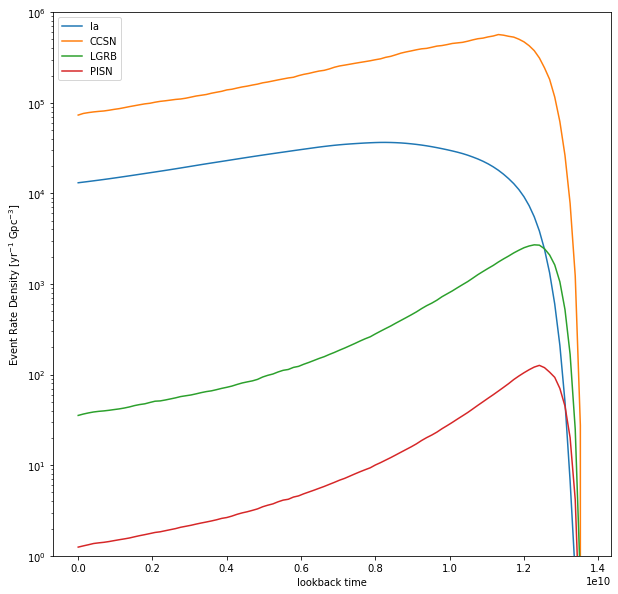

In [115]:
fig = plt.figure(figsize=(10,10))
plt.plot(edges[:-1],  np.sum(out[:,0], axis=0), label='Ia')
plt.plot(edges[:-1],  CCSN_rates, label='CCSN')
plt.plot(edges[:-1],  np.sum(out[:,5], axis=0), label='LGRB')
plt.plot(edges[:-1],  np.sum(out[:,6], axis=0), label='PISN')

plt.yscale('log')
plt.ylim(1e0, 1e6)
plt.xlabel('lookback time')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.legend()
plt.show()

### redshift analysis

For easy of comparison to observations we transformed the lookback time back into a redshift using the function below. This function stops working at very high redshift (>1000), but this is not required for comparison against observations. 

In [146]:

@np.vectorize
def approxZ(LB, omega0, omega1, hubble):
    """Internal function to convert a redshift into a lookback time.

    Parameters:
    LB : float
        lookback time in yrs
    omega0 : float
        the matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        the hubble parameter (0.6766 Planck 2018)
    """
    zmin = 1e-8
    zmax = 1000
    ztol = 1e-8
    maxfun = 5000
    f = lambda z : abs(calc_LB(z, omega0, omega1, hubble) - LB)

    z, _, _, _ = fminbound(f, zmin, zmax, maxfun=maxfun, full_output=1, xtol=ztol)
    return z

In [147]:
redshift_edges = approxZ(edges/1e9, omega_M, omega_L, h)

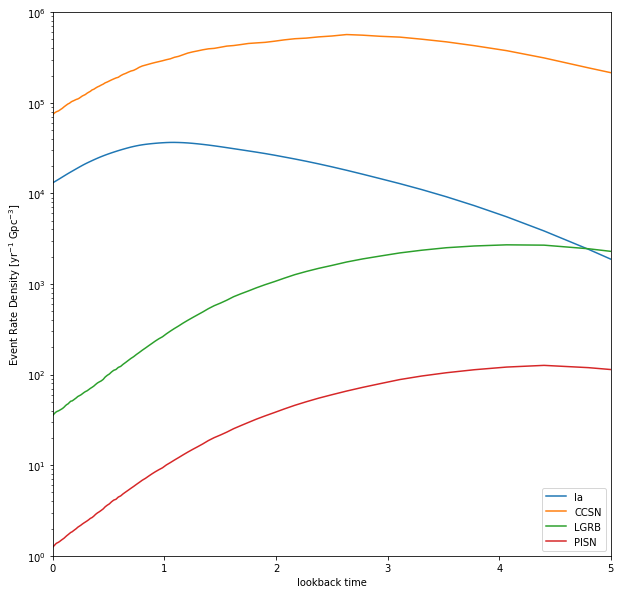

In [149]:
fig = plt.figure(figsize=(10,10))
plt.plot(redshift_edges[:-1],  np.sum(out[:,0], axis=0), label='Ia')
plt.plot(redshift_edges[:-1],  CCSN_rates, label='CCSN')
plt.plot(redshift_edges[:-1],  np.sum(out[:,5], axis=0), label='LGRB')
plt.plot(redshift_edges[:-1],  np.sum(out[:,6], axis=0), label='PISN')

plt.yscale('log')
plt.ylim(1e0, 1e6)
plt.xlim(0,5)
plt.xlabel('lookback time')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.legend()
plt.show()

### Gravitational wave transients

Because these delay time distributions are not included in the standard BPASS output, they are not included in the standard csp calculation method. Instead, we are required to use the internal functions of the `csp` package to calculate the compact object event rates.

We have made the compact object Delay Time Distributions available in the HDF5 file. These have been normalised to a rate of events yr$^{-1}$ M$_\odot^{-1}$


In [98]:
GW_events = ["BNS", "BHNS", "BBH"]

In [160]:
DTD = data['DTD']

In [193]:
# the number of bins of the final event rate calculation
nr_time_bins = 100


# split the final lookback time into the requested number of bins
# er_csp.now contains the hubble time in the given cosmology when initiated
time_edges = np.linspace(0, er_csp.now, nr_time_bins+1)

rates = {}
for event in GW_events:
    
    event_dtd = np.empty((13,51))

    # extract the DTD of the event type for all metallicities
    # It's important to give the metallicities in the same order as BPASS_METALLICITIES
    for i, Z in enumerate(BPASS_METALLICITIES):
        event_dtd[i] = DTD[event][Z]
    
    # reshape to include an additional dimension
    event_dtd = event_dtd.reshape(1,13,51)
    
    # this function requires the following input:
    # DTD (1x13x51) [event_type x metallicity x BPASS time bins]
    # SFH (13x100) [metallicites x SFH lookback time]
    # lookback_time (100) [SFH lookback time]
    # nr_time_bins (100) [nr_bins to split the final event rate time into]
    # t_hubble (1) [hubble time]
    rates[event] = er_csp._grid_rate_calculator_over_time(event_dtd, SFH_input[0], lookback_time, nr_time_bins, er_csp.now)        

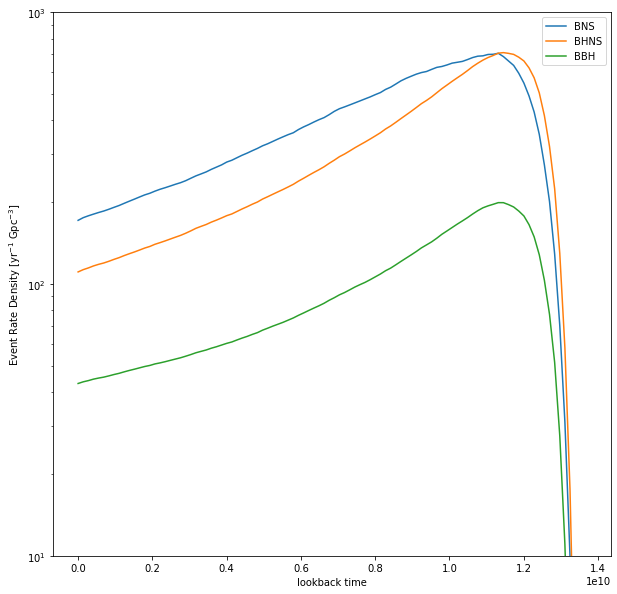

In [194]:
fig = plt.figure(figsize=(10,10))

for i in rates:
    plt.plot(edges[:-1],  np.sum(rates[i], axis=0)[0], label=i)

plt.yscale('log')
plt.ylim(1e1, 1e3)
plt.xlabel('lookback time')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.legend()
plt.show()

Similarly, we can also plot this over redshift as we have done before. We find the rates as shown in the paper.

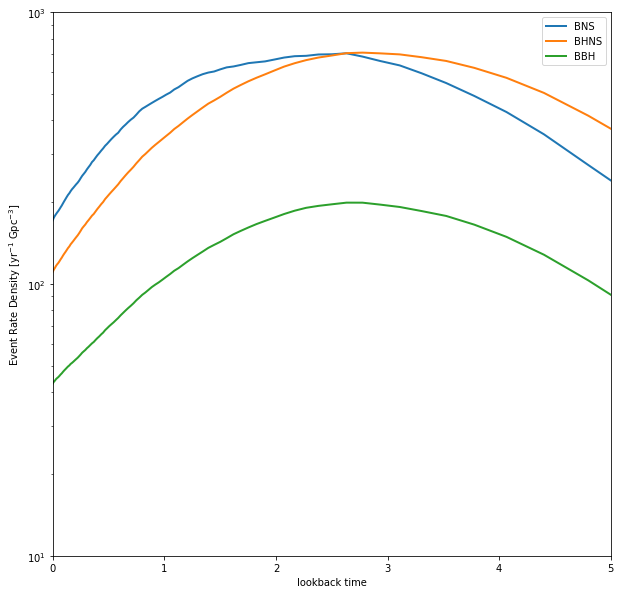

In [196]:
fig = plt.figure(figsize=(10,10))

for i in rates:
    plt.plot(redshift_edges[:-1],  np.sum(rates[i], axis=0)[0], label=i, lw=2)

plt.yscale('log')
plt.ylim(1e1, 1e3)
plt.xlim(0,5)
plt.xlabel('lookback time')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.legend()
plt.show()

In [ ]:
data.close()